![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SIR e algumas variações imediatas. Esta implementação serve como base para investigações mais profundas, e pode ser customizada ede diversos modos por eventuais interessados. Veremos ao final algumas idéias práticas de como fazer isso.

**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [548]:
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import seaborn as sns
sns.set()

In [549]:
plt.style.use('fivethirtyeight')

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [550]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [551]:
epidemic_duration_in_days = 365

Tamanho da população.

In [552]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [553]:
initially_infected = 52

## Modelo SIR

O [modelo SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

In [554]:
def s(t, S, I, R, beta, gamma):
    delta = - (beta * I * S) / population_size
    
    if abs(delta) >= S:
        #raise Exception("S delta too large.")
        return -S
    if S + delta <= 0:
        #raise Exception("S delta is negative.")
        return 0
    else:
        return delta

In [555]:
def i(t, S, I, R, beta, gamma):
    delta_s = ((beta * I * S) / population_size) 
    delta = delta_s - (gamma*I)
    
    if abs(delta_s) >= S:
        #raise Exception("I delta too large.")
        return S    
    elif I + delta <= 0:
        #raise Exception("I delta is negative.")
        return 0
    
    else:
        return delta

In [556]:
def r(t, S, I, R, beta, gamma):
    return gamma*I

A simulação então pode ser definida do seguinte modo.

In [557]:
def simulate(S, I, R, beta, gamma, epidemic_start_date, epidemic_duration_in_days, s_func, i_func, r_func):
    assert beta <= 1.0, "beta must be <= 1.0"
    assert gamma <= 1.0, "gamma must be <= 1.0"
    
    generated_data = [] # initial data
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, I, R))
        
        S_next = S + s_func(t, S, I, R, beta, gamma)
        I_next = I + i_func(t, S, I, R, beta, gamma)
        R_next = R + r_func(t, S, I, R, beta, gamma)
        #print(s_func(t, S, I, R, beta, gamma), i_func(t, S, I, R, beta, gamma), r_func(t, S, I, R, beta, gamma))

        S = S_next
        I = I_next
        R = R_next
        #print(S + I + R)
        assert math.isclose(S + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
        
        
    return pd.DataFrame(generated_data,
                        columns=['S', 'I', 'R'],
                        index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [558]:
beta = 0.3    # S to I rate
gamma = 0.03  # I to R rate

,S,I,R
2020-03-19,2.000000e+09,277.095418,25.010604
2020-03-20,2.000000e+09,351.911169,33.323467
2020-03-21,2.000000e+09,446.927164,43.880802
2020-03-22,1.999999e+09,567.597465,57.288617
2020-03-23,1.999999e+09,720.848728,74.316541


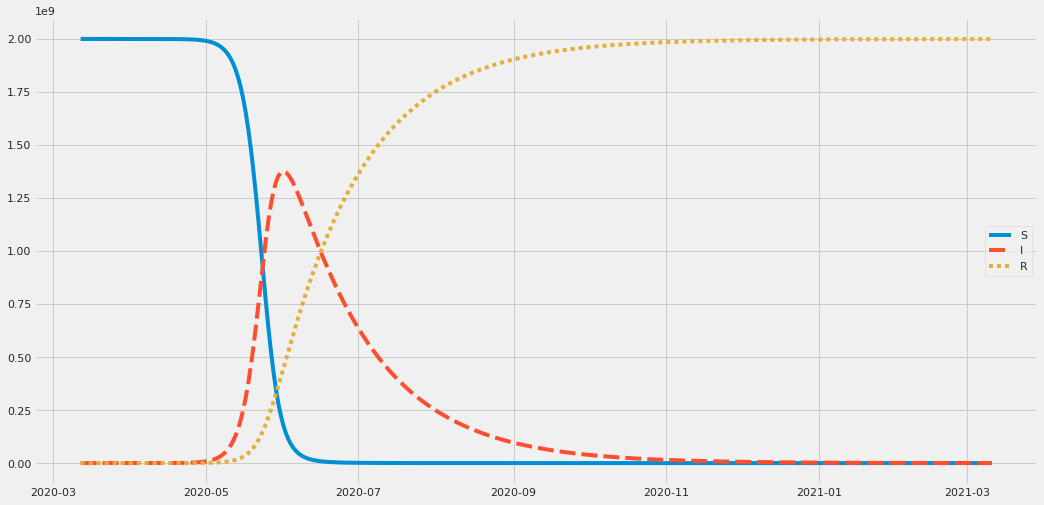

In [559]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              I=initially_infected, 
                              R=0, 
                              beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              i_func=i, 
                              r_func=r)
sns.lineplot(data=df_simulation_data)
df_simulation_data['2020-03-19':].head()

### Escolha de beta e gamma
Evidentemente, a escolha das taxas de contaminação (beta) e recuperação (gamma) é fundamental. Como estimar bons números? Vamos explorar alguns cenários.

#### Cenário 1

Suponhamos que a taxa de contaminação seja composta por uma taxa diária de interação com infectados e uma de efetiva transmissão.

In [560]:
interact_prob = 0.5
transm_prob = 0.8
beta_scn1 = interact_prob * transm_prob
beta_scn1

0.4

Suponhamos um tempo médio de recuperação em dias.

In [561]:
avg_recovery_time = 30

In [562]:
gamma_scn1 = 1.0/avg_recovery_time
gamma_scn1

0.03333333333333333

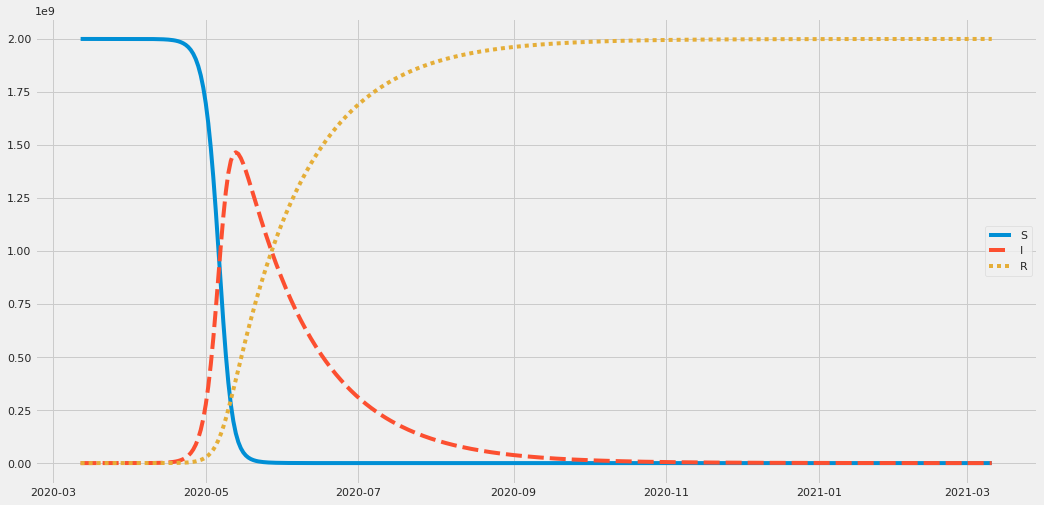

In [563]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              I=initially_infected, 
                              R=0, 
                              beta=beta_scn1, gamma=gamma_scn1, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              i_func=i, 
                              r_func=r)
sns.lineplot(data=df_simulation_data)

## Variação 1: SIR + parâmetros dinâmicos
Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo.

Para alcançar esse efeito, iremos refazer a função de simulação de modo que possa aceitar dicionários de parâmetros, nos quais as chaves denotam os dias, e os valores os parâmetros naquele momento.

In [564]:
def simulate_var1(S, I, R, betas, gammas, epidemic_start_date, epidemic_duration_in_days, s_func, i_func, r_func):
    
    generated_data = [] # initial data
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, I, R))
        
        S_next = S + s_func(t, S, I, R, betas[t], gammas[t])
        I_next = I + i_func(t, S, I, R, betas[t], gammas[t])
        R_next = R + r_func(t, S, I, R, betas[t], gammas[t])

        S = S_next
        I = I_next
        R = R_next
        #print(S + I + R)
        assert math.isclose(S + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
        
        
    return pd.DataFrame(generated_data,
                        columns=['S', 'I', 'R'],
                        index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))

Convém ter uma função para montar as sequências de parâmetros (ver exemplo a seguir para entender seu uso)

In [565]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    for value, length in regimens:
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

Vejamos um exemplo. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante. *Gamma* será definido de forma similar. 

In [566]:
betas = dynamic_parameter([(0.3, 30), 
                           (0.25, 60), 
                           (0.2, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gammas = dynamic_parameter([(0.03, 30), 
                            (0.04, 60), 
                            (0.05, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

Então podemos aplicar a simulação.

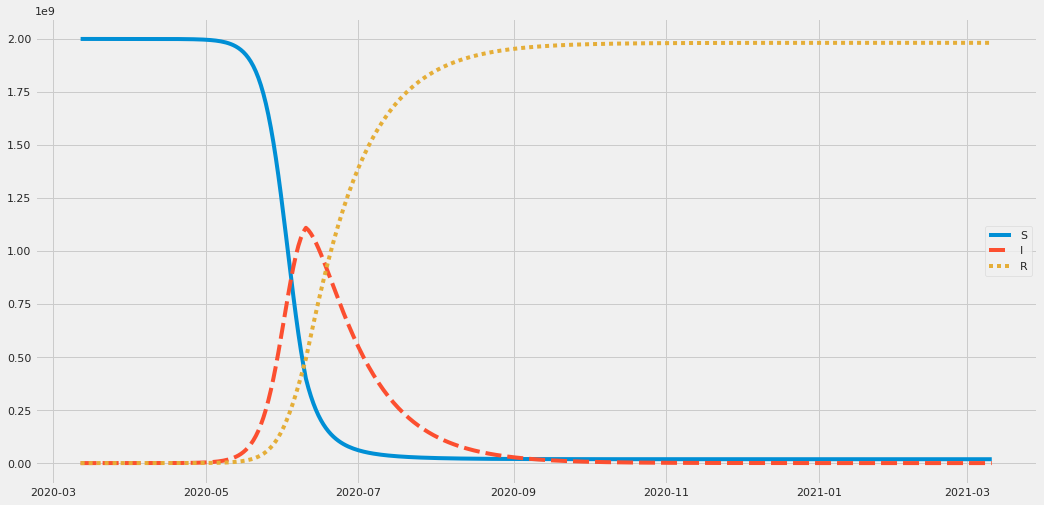

In [567]:
df_simulation_data = simulate_var1(S=population_size - initially_infected, 
                              I=initially_infected, 
                              R=0, 
                              betas=betas, 
                              gammas=gammas, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              i_func=i, 
                              r_func=r)
sns.lineplot(data=df_simulation_data)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade. Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ).

In [568]:
# source: https://ourworldindata.org/coronavirus-source-data 
# as of 2020-03-22
df_covid19_brazil = pd.DataFrame.from_records([[pd.Timestamp('2020-03-12'), 52],
                                               [pd.Timestamp('2020-03-13'), 77],
                                               [pd.Timestamp('2020-03-14'), 98],
                                               [pd.Timestamp('2020-03-15'), 121],
                                               [pd.Timestamp('2020-03-16'), 200], 
                                               [pd.Timestamp('2020-03-17'), 234], 
                                               [pd.Timestamp('2020-03-18'), 291],
                                               [pd.Timestamp('2020-03-19'), 428],
                                               [pd.Timestamp('2020-03-20'), 621],
                                               [pd.Timestamp('2020-03-21'), 904],
                                               [pd.Timestamp('2020-03-22'), 1128]
                                              ], 
                                              columns=['date', 'infected']).set_index(['date']) 
df_covid19_brazil.head(5)

,infected
date,
2020-03-12,52
2020-03-13,77
2020-03-14,98
2020-03-15,121
2020-03-16,200


### Para Modelo SIR Simples

No modelo simples, há dois parâmetros principais, *beta* e *gamma*.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [569]:
def objective_for_simulation(args):
    beta, gamma = args
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              I=initially_infected, 
                              R=0, 
                              beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              i_func=i, 
                              r_func=r)
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_covid19_brazil.index.values)]
    df_diff = df_covid19_brazil['infected'] - df_simulation_data_filtered['I']
    
    mae = np.mean(abs(df_diff.values)) #mean absolute error

    return mae

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [577]:
space = (hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0))

best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000)

print("Best parameters found:", best)

100%|██████████| 1000/1000 [00:14<00:00, 69.39trial/s, best loss: 0.4766992565143601]
Best parameters found: {'beta': 0.8551293119435193, 'gamma': 0.49336016789964154}


Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

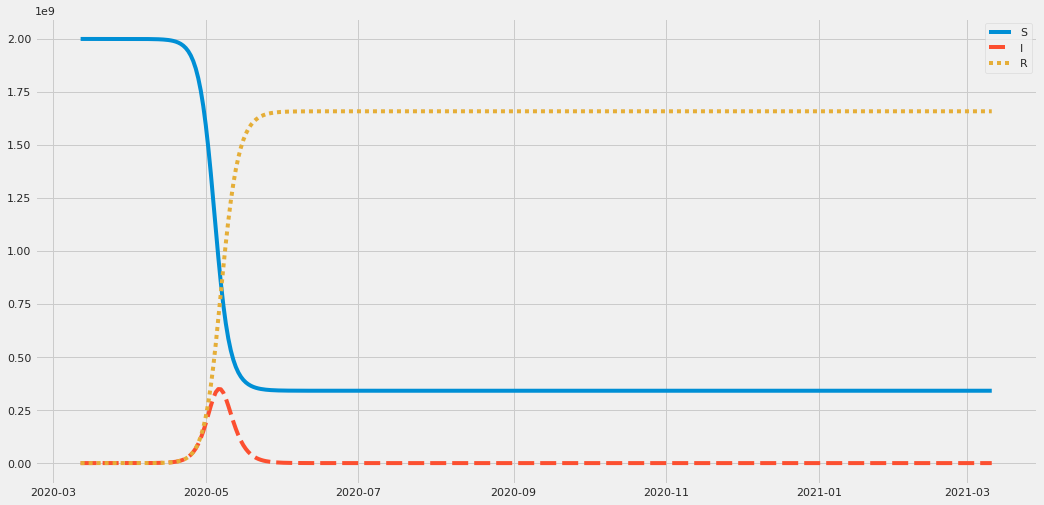

In [571]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              I=initially_infected, 
                              R=0, 
                              beta=best['beta'], gamma=best['gamma'], 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              i_func=i, 
                              r_func=r)
sns.lineplot(data=df_simulation_data, markers=False)

,S,I,R
2020-03-16,2.000000e+09,178.856105,121.695187
2020-03-17,2.000000e+09,243.572838,183.779042
2020-03-18,1.999999e+09,331.706459,268.327124
2020-03-19,1.999999e+09,451.730049,383.467816
2020-03-20,1.999999e+09,615.182548,540.270643
2020-03-21,1.999998e+09,837.778086,753.810483
2020-03-22,1.999998e+09,1140.916699,1044.616844
2020-03-23,1.999997e+09,1553.741658,1440.647535
2020-03-24,1.999996e+09,2115.941184,1979.976464
2020-03-25,1.999994e+09,2881.563862,2714.453968


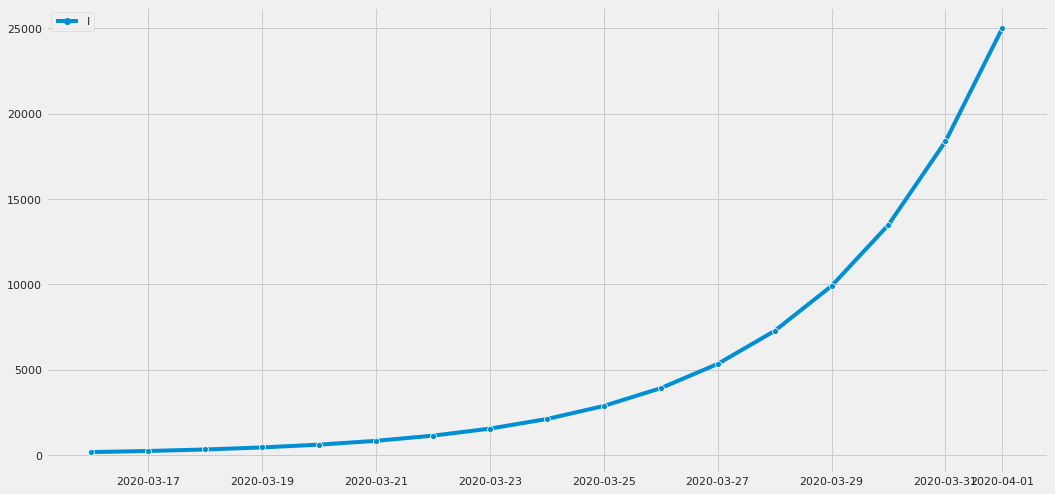

In [576]:
sns.lineplot(data=df_simulation_data[['I']]['2020-03-16':'2020-04-01'],  markers=True)
df_simulation_data['2020-03-16':'2020-04-01'].head(15)

### Para Variação 1 do Modelo SIR

Vamos experimentar agora introduzindo medidas de mitigação que reduzem o contágio após alguns dias iniciais com os parâmetros inferidos anteriormente.

In [615]:
#betas = dynamic_parameter([(best['beta'], 10)] + \
#                           [(best['beta']/(1.0 + 0.1*i), 5) for i in range(1, 20)], min_length=epidemic_duration_in_days)

betas = dynamic_parameter([(best['beta'], 12)] + \
                           [(best['beta']/3, 100)], min_length=epidemic_duration_in_days)


gammas = dynamic_parameter([(best['gamma'], 30)], min_length=epidemic_duration_in_days)

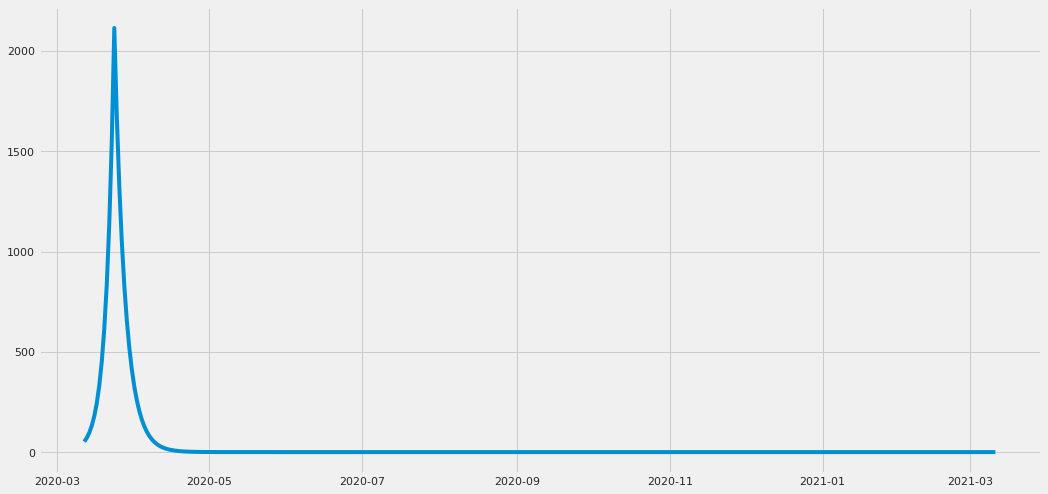

In [616]:
df_simulation_data_mitigated =  simulate_var1(S=population_size - initially_infected, 
                                              I=initially_infected, 
                                              R=0, 
                                              betas=betas, 
                                              gammas=gammas, 
                                              epidemic_start_date=epidemic_start_date,
                                              epidemic_duration_in_days=epidemic_duration_in_days, 
                                              s_func=s, 
                                              i_func=i, 
                                              r_func=r)

sns.lineplot(data=df_simulation_data_mitigated['I'] )
#sns.lineplot(data=df_simulation_data)

,S,I,R
2020-03-16,2.000000e+09,178.820468,172.950569
2020-03-17,1.999999e+09,243.512169,261.173465
2020-03-18,1.999999e+09,331.607305,381.312669
2020-03-19,1.999999e+09,451.572495,544.914505
2020-03-20,1.999999e+09,614.937297,767.702386
2020-03-21,1.999998e+09,837.402273,1071.087955
2020-03-22,1.999997e+09,1140.347893,1484.228881
2020-03-23,1.999996e+09,1552.889295,2046.831109
2020-03-24,1.999995e+09,2114.674336,2812.964832
2020-03-25,1.999994e+09,1674.150102,3856.260918


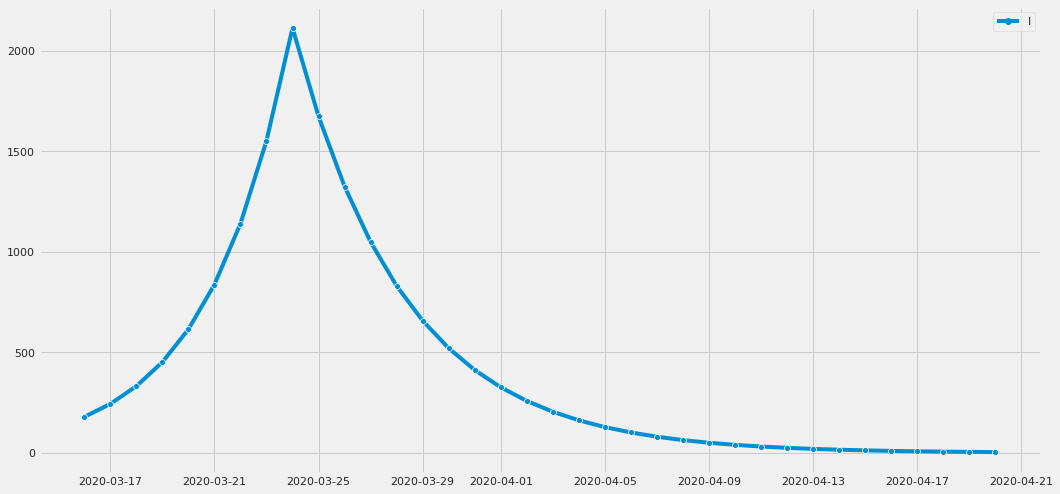

In [617]:
sns.lineplot(data=df_simulation_data_mitigated[['I']]['2020-03-16':'2020-04-20'],  markers=True)
df_simulation_data_mitigated['2020-03-16':'2020-04-20'].head(15)

Comparando as versões com e sem mitigação, temos o seguinte.

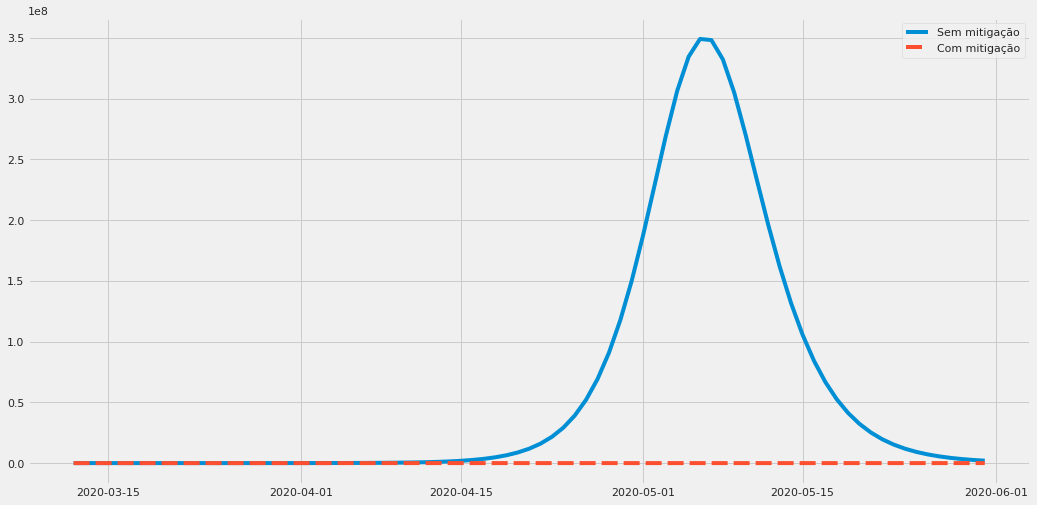

In [605]:
sns.lineplot(data=pd.concat([df_simulation_data['I'].rename('Sem mitigação'), 
                             df_simulation_data_mitigated['I'].rename('Com mitigação')], axis=1)['2020-03':'2020-05'])